### ตรวจสอบการใช้งาน GPU

In [1]:
!nvidia-smi

Sun Nov 23 14:11:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### ติดตั้ง Kaggle Library

In [2]:
!pip install kaggle

### Upload kaggle.json

In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chananyaaiamprakhon","key":"998b00069a09c27c985b730b672a1884"}'}

### สร้าง Folder kaggle บน Google Colab เพื่อเก็บไฟล์ kaggle.json

In [4]:
!mkdir kaggle

### ย้ายไฟล์ kaggle.json ไปยัง Folder kaggle

In [5]:
!mv kaggle.json kaggle

### เปลี่ยน Permission ของไฟล์ kaggle.json

In [6]:
!chmod 600 /content/kaggle/kaggle.json

### Config Kaggle Environment

In [7]:
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content/kaggle"

### Copy API command & Download Pneumonia X-Ray Images Dataset

In [8]:
!kaggle datasets download -d jtiptj/chest-xray-pneumoniacovid19tuberculosis

Dataset URL: https://www.kaggle.com/datasets/jtiptj/chest-xray-pneumoniacovid19tuberculosis
License(s): other
 97% 1.69G/1.74G [00:12<00:00, 52.4MB/s]
100% 1.74G/1.74G [00:12<00:00, 150MB/s] 


### สร้าง Folder pneumonia-xray-images แล้ว Unzip Dataset

In [9]:
!mkdir chest-xray-pneumoniacovid19tuberculosis && unzip -q chest-xray-pneumoniacovid19tuberculosis.zip -d chest-xray-pneumoniacovid19tuberculosis

### Import Library และกำหนดค่า Parameter ที่จำเป็น

In [10]:
# library สำหรับการใช้คำสั่งต่างๆ เพื่อสร้าง machine learning
import tensorflow as tf

#ใช้สำหรับลดอัตราการเรียนเมื่อ model ไม่มีการเรียนรู้เพิ่มเติม
ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau

#ใช้ Image Augmentation เพื่อแก้ปัญหา Over Fitting
ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator

# ใช้สำหรับรายงานผล classification report & confusion matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# ใช้คำนวณค่า True Positive Rate และ False Positive Rate
from sklearn.metrics import roc_curve, auc

# ใช้ในการ plor graph
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.express as px

# ใช้ในการคำนวนทางคณิตศาสตร์
import numpy as np

# ใช้ในสำหรับจัดการ data frame
import pandas as pd

from tensorflow.keras.callbacks import EarlyStopping

### สร้างตัวแปรเก็บ path ของ dataset

In [11]:
# Define the general path
path = '/content/chest-xray-pneumoniacovid19tuberculosis/'

### Rescale

* ทำ Data Augmentation ซึ่งถือว่าเป็นการ Regularization แบบหนึ่ง เพราะจะช่วยลด Overfiting ได้ โดยใช้ ImageDataGenerator ตามด้วยพารามิเตอร์ rescale = 1./255
* พารามิเตอร์ rescale คือ การปรับค่าสัมประสิทธิ์ RGB ในช่วง 0-255 ให้กลายเป็นช่วง 0-1
* เพราะช่วง 0-255 จะสูงเกินไปสำหรับการประมวลผลของโมเดลโดยการกำหนดให้ rescale = 1./255

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

### Load ภาพสำหรับการ Train แบบ Grayscale ด้วย datagen

* กำหนด class_mode เป็น Categorical เพื่อกำหนด Format ของผลเฉลยเป็นแบบ One-hot

* Training Set ใช้สำหรับป้อนให้ใช้เทรน
* Validation Set ใช้สำหรับทดสอบหา Metrics หลังจากเทรนเสร็จว่าโมเดลทำงานได้ดีแค่ไหน และหลังจากจูนแต่ละครั้งโมเดลไหนทำงานได้ดีกว่ากัน
* Test Set ใช้สำหรับทดสอบหลังจากได้โมเดลที่ดีที่สุดมาแล้ว ว่าโมเดลจะทำงานได้ดีแค่ไหนกับข้อมูลที่ไม่เคยเห็นมาก่อน

In [13]:
# Load the images
train_generator = train_datagen.flow_from_directory(directory=path +'train',
                                                    target_size=(224, 224),
                                                    color_mode="grayscale",
                                                    batch_size=32,
                                                    class_mode="categorical",
                                                    shuffle=True,seed=42)

val_generator = val_datagen.flow_from_directory(directory=path +'val',
                                                    target_size=(224, 224),
                                                    color_mode="grayscale",
                                                    batch_size=32,
                                                    class_mode="categorical",
                                                    shuffle=True,seed=42)


test_generator = test_datagen.flow_from_directory(directory=path +'test',
                                                  target_size=(224, 224),
                                                  color_mode="grayscale",
                                                  batch_size=1,
                                                  class_mode=None,
                                                  shuffle=False,
                                                  seed=42)

Found 6326 images belonging to 4 classes.
Found 38 images belonging to 4 classes.
Found 771 images belonging to 4 classes.


### label

* ใช้ class_indices ที่สามารถ return dictionary ที่ map ชื่อคลาสกับหมายเลขคลาสในรูปแบบ {key:value}

In [14]:
train_generator.class_indices

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2, 'TURBERCULOSIS': 3}

In [15]:
labels = list(train_generator.class_indices.keys())
labels

['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']

### นิยาม Model แบบ Convolutional Neural Network (CNN)

In [16]:
model = tf.keras.Sequential()

# Feature Extraction
# 1 CNN layer
model.add(tf.keras.layers.Conv2D(filters=128,strides= 1, kernel_size = (5,5), activation='relu', input_shape=(224,224,1,)))
model.add(tf.keras.layers.MaxPool2D(3,3))
model.add(tf.keras.layers.Conv2D(filters=64,kernel_size = (5,5),activation='relu'))
model.add(tf.keras.layers.MaxPool2D(3,3))
# 2 CNN layer
model.add(tf.keras.layers.Conv2D(filters=30,kernel_size = (3,3),activation='relu'))
model.add(tf.keras.layers.MaxPool2D(2,2))
model.add(tf.keras.layers.Conv2D(filters=30,kernel_size = (3,3),activation='relu'))
model.add(tf.keras.layers.MaxPool2D(2,2))

# Image Classification
# FULLY CONNECTED LAYER
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(2048,activation='relu'))
model.add(tf.keras.layers.Dense(512,activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(256,activation='relu'))
model.add(tf.keras.layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(32,activation='relu'))
# OUTPUT LAYER
model.add(tf.keras.layers.Dense(4,activation = 'softmax'))

# Compile Model
model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 220, 220, 128)  │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 69, 69, 64)     │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 30)     │        17,310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 30)       │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │       985,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,417,796 (9.22 MB)

 Trainable params: 2,417,796 (9.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.1, min_lr=0.000001)
#callbacks_list = [learning_rate_reduction]

### คำนวณ Step ของการ Train การ Validate และการ Test

In [17]:
# Hyperparameters
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size

# Train the model
his = model.fit(train_generator,steps_per_epoch=STEP_SIZE_TRAIN,
          validation_data=val_generator,verbose= 1,
          validation_steps=STEP_SIZE_VALID,
          epochs=30)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 76s 321ms/step - accuracy: 0.6217 - loss: 1.0038 - val_accuracy: 0.5625 - val_loss: 0.9733
Epoch 2/30
  1/197 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.7188 - loss: 0.6721

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7188 - loss: 0.6721 - val_accuracy: 0.4688 - val_loss: 1.1946
Epoch 3/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 52s 266ms/step - accuracy: 0.8343 - loss: 0.4162 - val_accuracy: 0.7188 - val_loss: 0.9020
Epoch 4/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8438 - loss: 0.3108 - val_accuracy: 0.5312 - val_loss: 0.8285
Epoch 5/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 52s 266ms/step - accuracy: 0.8994 - loss: 0.2964 - val_accuracy: 0.7812 - val_loss: 0.6509
Epoch 6/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8750 - loss: 0.2300 - val_accuracy: 0.8438 - val_loss: 0.5070
Epoch 7/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 53s 265ms/step - accuracy: 0.9208 - loss: 0.2377 - val_accuracy: 0.7188 - val_loss: 0.8575
Epoch 8/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9375 - loss: 0.1491 - val_accuracy: 0.5625 - val_loss: 1.2831
Epoch 9/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 52s 265ms/step - accuracy: 0.9379 - loss: 0.1884 - val_accuracy: 0

In [19]:
# Evaluate the model
model.evaluate(val_generator,steps=STEP_SIZE_VALID)
# Save the model
model.save("ChestXRayModel.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.7500 - loss: 0.4792


In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Predict Output
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_generator.reset()
pred=model.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1)

predicted_class_indices=np.argmax(pred,axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

771/771 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step


In [21]:
current_idx = 0
count_accurate= 0
Actual = []
for i in predictions:
    string = test_generator.filenames[current_idx]
    substr = '/'
    actual = string[:string.find(substr)]
    Actual.append(actual)
    pred = predictions[current_idx]
    if actual == pred:
        count_accurate += 1
    current_idx +=1
acc = count_accurate/771
print(f"The accuracy on predicted the test images is {round(acc*100,2)}%.")

The accuracy on predicted the test images is 79.9%.


In [22]:
from sklearn.metrics import classification_report, confusion_matrix
cm = classification_report(Actual, predictions)
print(cm)

               precision    recall  f1-score   support

      COVID19       0.86      0.95      0.90       106
       NORMAL       0.96      0.38      0.54       234
    PNEUMONIA       0.76      0.99      0.86       390
TURBERCULOSIS       0.77      0.98      0.86        41

     accuracy                           0.80       771
    macro avg       0.84      0.82      0.79       771
 weighted avg       0.83      0.80      0.77       771



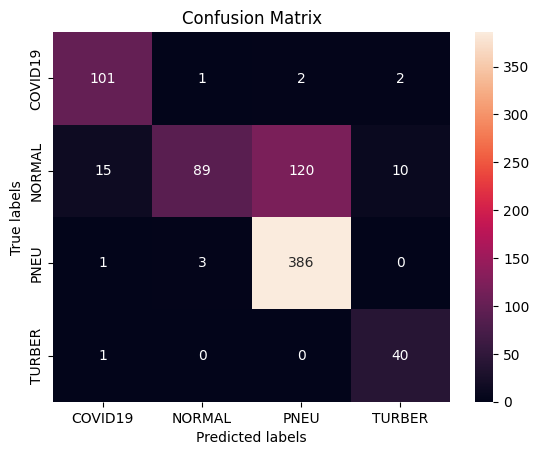

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(Actual, predictions)
ax= plt.subplot()
sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['COVID19', 'NORMAL', 'PNEU', 'TURBER']); ax.yaxis.set_ticklabels(['COVID19', 'NORMAL', 'PNEU', 'TURBER']);

In [24]:
h1 = go.Scatter(y=his.history['loss'],
                    mode="lines",
                    line=dict(
                        width=2,
                        color='blue'),
                        name="loss"
                   )
h2 = go.Scatter(y=his.history['val_loss'],
                    mode="lines",
                    line=dict(
                        width=2,
                        color='red'),
                        name="val_loss"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Loss',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data, layout=layout1)
plotly.offline.iplot(fig1)

In [25]:
h1 = go.Scatter(y=his.history['accuracy'],
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="acc"
                   )
h2 = go.Scatter(y=his.history['val_accuracy'],
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_acc"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Accuracy',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
plotly.offline.iplot(fig1)

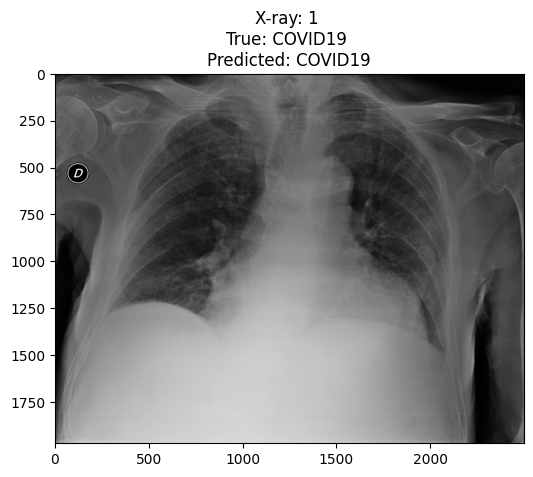

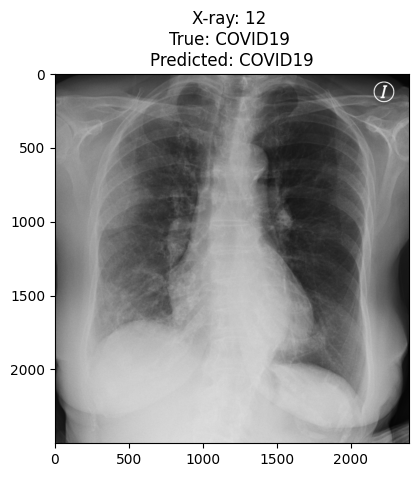

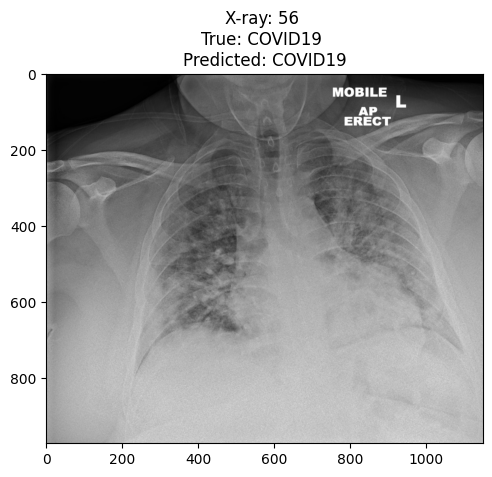

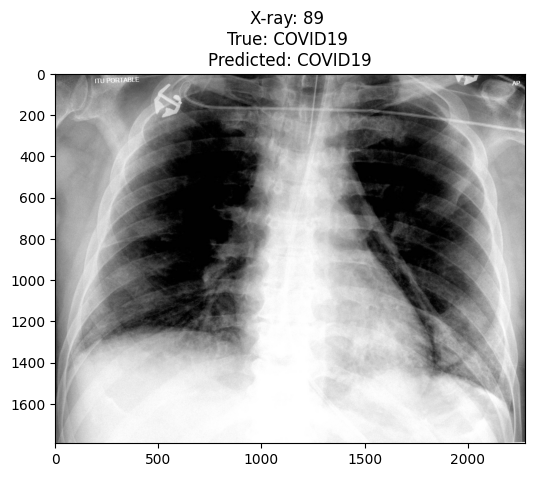

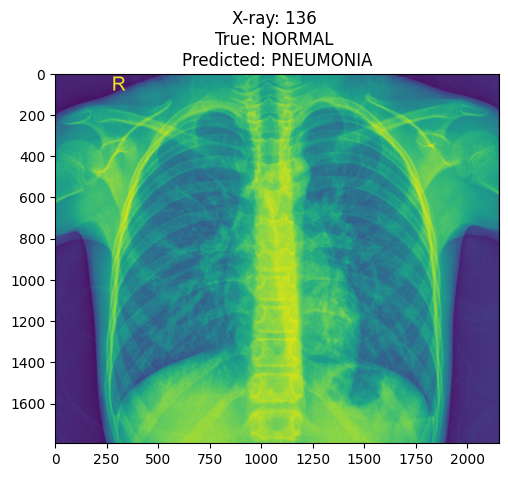

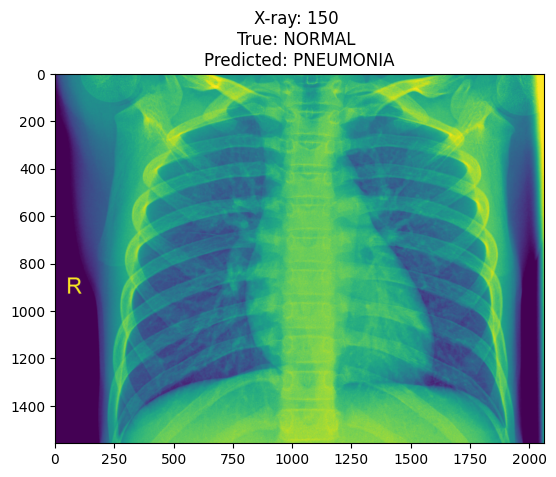

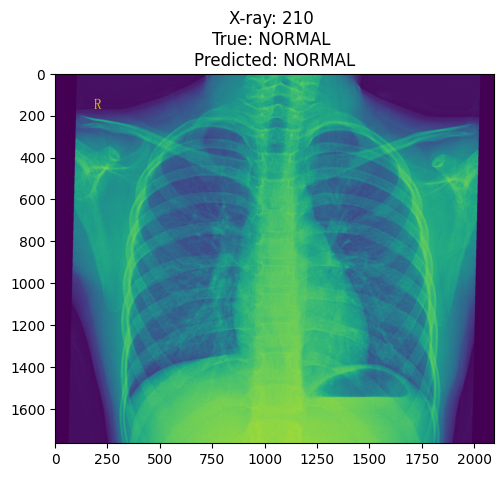

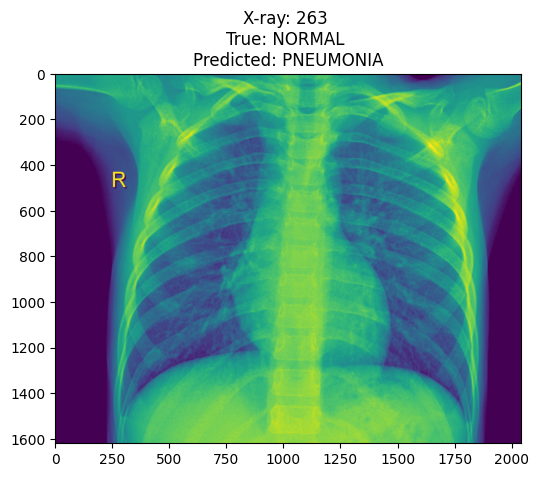

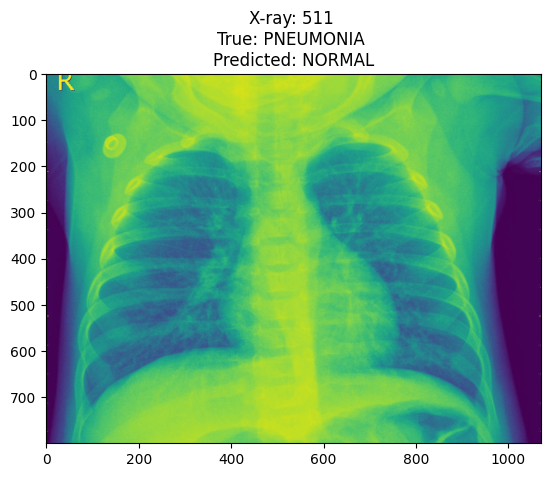

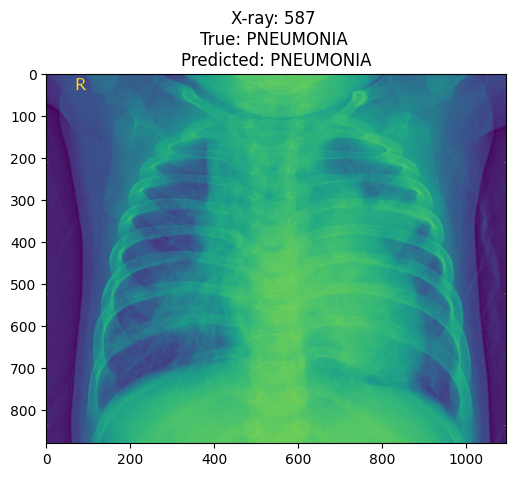

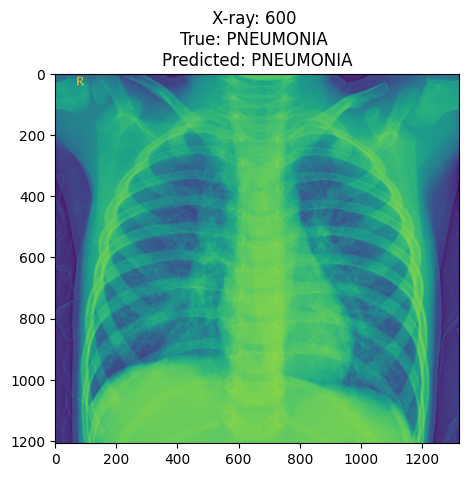

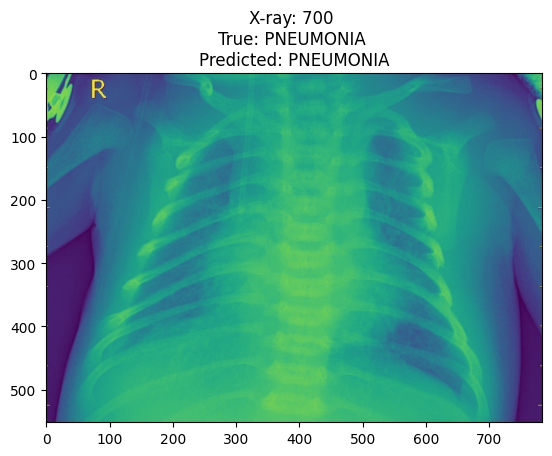

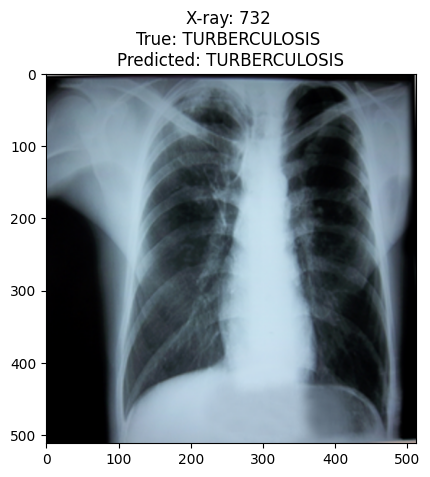

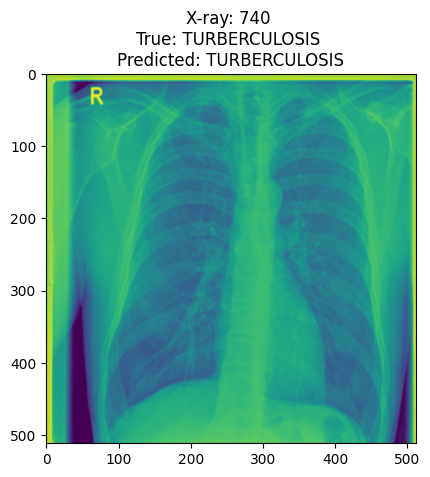

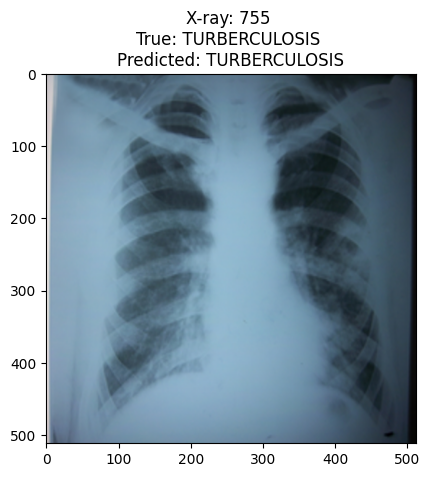

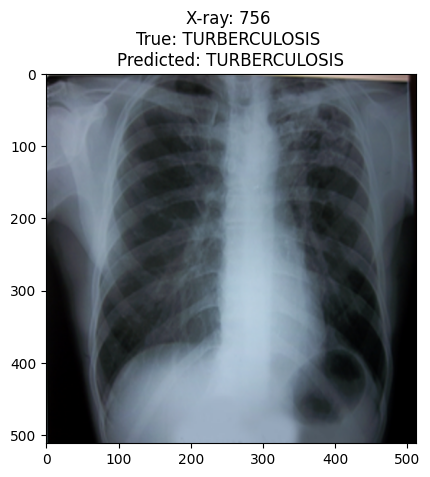

In [26]:
# Selected some images to see its predictions
current = [1,12,56,89,136,150,210,263,511,587,600,700,732,740,755,756]
for i in current:
    plt.imshow(plt.imread(path+'test/'+test_generator.filenames[i]))
    string = test_generator.filenames[i]
    substr = '/'
    actual = string[:string.find(substr)]
    plt.title(f"X-ray: {i} \nTrue: {actual} \nPredicted: {predictions[i]}")
    plt.show()

In [ ]:
import pandas as pd

# Save results to csv file
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)

In [32]:
model = tf.keras.models.load_model("/content/ChestXRayModel.keras")
model.save("/content/ChestXRayModel.h5")
